In [101]:
import math
import random
import string

class NN:
  def __init__(self, NI, NH, NO):
    # number of nodes in layers
    self.ni = NI + 1 # +1 for bias
    self.nh = NH
    self.no = NO
    
    # initialize node-activations
    self.ai, self.ah, self.ao = [],[], []
    self.ai = [1.0]*self.ni
    self.ah = [1.0]*self.nh
    self.ao = [1.0]*self.no

    # create node weight matrices
    self.wi = makeMatrix (self.ni, self.nh)
    self.wo = makeMatrix (self.nh, self.no)
    # initialize node weights to random vals
    randomizeMatrix ( self.wi, -0.2, 0.2 )
    randomizeMatrix ( self.wo, -2.0, 2.0 )
    # create last change in weights matrices for momentum
    self.ci = makeMatrix (self.ni, self.nh)
    self.co = makeMatrix (self.nh, self.no)
    
  def runNN (self, inputs):
    if len(inputs) != self.ni-1:
      print 'incorrect number of inputs'
    
    for i in range(self.ni-1):
      self.ai[i] = inputs[i]
      
    for j in range(self.nh):
      sum = 0.0
      for i in range(self.ni):
        sum +=( self.ai[i] * self.wi[i][j] )
      self.ah[j] = sigmoid (sum)
    
    for k in range(self.no):
      sum = 0.0
      for j in range(self.nh):        
        sum +=( self.ah[j] * self.wo[j][k] )
      self.ao[k] = sigmoid (sum)
      
    return self.ao
      
      
  
  def backPropagate (self, y, N, M):
    # http://www.youtube.com/watch?v=aVId8KMsdUU&feature=BFa&list=LLldMCkmXl4j9_v0HeKdNcRA
    
    # calc output deltas
    # we want to find the instantaneous rate of change of ( error with respect to weight from node j to node k)
    # output_delta is defined as an attribute of each ouput node. It is not the final rate we need.
    # To get the final rate we must multiply the delta by the activation of the hidden layer node in question.
    # This multiplication is done according to the chain rule as we are taking the derivative of the activation function
    # of the ouput node.
    # dE/dw[j][k] = (t[k] - ao[k]) * s'( SUM( w[j][k]*ah[j] ) ) * ah[j]
    output_deltas = [0.0] * self.no
    for k in range(0,self.no):
      error =  y[k] - self.ao[k]
      output_deltas[k] =  error * dsigmoid(self.ao[k]) 
   
    # update output weights
    for j in range(0,self.nh):
      for k in range(0,self.no):
        # output_deltas[k] * self.ah[j] is the full derivative of dError/dweight[j][k]
        change = output_deltas[k] * self.ah[j]
        self.wo[j][k] += N*change + M*self.co[j][k]
        self.co[j][k] = change

    # calc hidden deltas
    hidden_deltas = [0.0] * self.nh
    for j in range(0,self.nh):
      error = 0.0
      for k in range(0,self.no):
        error += output_deltas[k] * self.wo[j][k]
      hidden_deltas[j] = error * dsigmoid(self.ah[j])
    
    #update input weights
    for i in range (0,self.ni):
      for j in range (0,self.nh):
        change = hidden_deltas[j] * self.ai[i]
        #print 'activation',self.ai[i],'synapse',i,j,'change',change
        self.wi[i][j] += N*change + M*self.ci[i][j]
        self.ci[i][j] = change
        
    # calc combined error
    # 1/2 for differential convenience & **2 for modulus
    error = 0.0
    for k in range(0,len(y)):
      error += 0.5 * (y[k]-self.ao[k])**2
    return error
        
        
  def weights(self):
    print 'Input weights:'
    for i in range(self.ni):
      print self.wi[i]
    print
    print 'Output weights:'
    for j in range(self.nh):
      print self.wo[j]
    print ''

  
  def train (self, patterns, yhat, max_iterations = 1000, N=0.5, M=0.1):
    for i in range(max_iterations):
        for j in range(len(patterns)):
            self.runNN(patterns[j])
            error = self.backPropagate(yhat[j], N, M)
        print 'Combined error', error
    self.test(patterns)
    

def sigmoid (x):
  return expit( x )
  
# the derivative of the sigmoid function in terms of output
# proof here: 
# http://www.math10.com/en/algebra/hyperbolic-functions/hyperbolic-functions.html
def dsigmoid (y):
  return expit(y)*(1-expit(y))

def makeMatrix ( I, J, fill=0.0):
  m = []
  for i in range(I):
    m.append([fill]*J)
  return m
  
def randomizeMatrix ( matrix, a, b):
  for i in range ( len (matrix) ):
    for j in range ( len (matrix[0]) ):
      matrix[i][j] = random.uniform(a,b)




In [95]:
## import data into a ndarray 
import gzip
import numpy as np 
import random
from scipy.special import expit
f = gzip.open('zip.train.gz', 'rb')
trainData = np.genfromtxt(f)
f.close()
f = gzip.open('zip.test.gz', 'rb')
testData = np.genfromtxt(f)
f.close()

In [96]:
## separate the classes and the training data
Y = trainData[:,0]
X = trainData[:,1:]
## same for test data
Y_test = testData[:,0]
X_test = testData[:,1:]


In [97]:
## reduce dimensionality down to 40 principle components 
from sklearn.decomposition import PCA
pca = PCA(n_components = 40 )
pca.fit(X)
X_train_pca = pca.transform(X)
train =  list(X_train_pca)
## repeat for test data
pca.fit(X_test)
X_test_pca = pca.transform(X_test)
test =  list(X_test_pca)

In [98]:
## create target matrix (10 x size of train data [7291]) from target values
yhat = np.zeros((Y.shape[0],10))
for i in range(0 ,Y.shape[0]):
    yhat[i,Y[i]] = 1 
target = list(yhat)
## repeat for test data
yhat_test = np.zeros((Y_test.shape[0],10))
for i in range(0 ,Y_test.shape[0]):
    yhat_test[i,Y_test[i]] = 1 
target_test = list(yhat_test)

In [103]:
##myNN = NN ( 40, 20,10)
myNN.train(train, target)
##net_error = network.train(train, target,.1 )

KeyboardInterrupt: 

In [104]:
from sklearn.metrics import confusion_matrix
classified_train = [] 
for item in train:
    yhat = list(myNN.runNN(item))
    classified_train.append(yhat.index(max(yhat)))

truth_train = []
for i in range(0,len(train)):
    y = list(target[i])
    truth_train.append(y.index(max(y)))

classified_test = [] 
for item in test:
    yhat_2 = list(myNN.runNN(item))
    classified_test.append(yhat_2.index(max(yhat_2)))

truth_test = []
for i in range(0,len(test)):
    y_2 = list(target_test[i])
    truth_test.append(y_2.index(max(y_2)))

dissimilar_test = 0.0
for i in range(0, len(test)):
    if(truth_test[i] != classified_test[i]):
        dissimilar_test += 1 

dissimilar_train = 0.0
for i in range(0, len(train)):
    if(truth_train[i] != classified_train[i]):
        dissimilar_train += 1 

percent_error = dissimilar_train/len(train)
print "Percent Error train", percent_error
        
percent_error = dissimilar_test/len(test)
print "Percent Error test", percent_error

cm1 = confusion_matrix(truth_train, classified_train)    
cm2 = confusion_matrix(truth_test, classified_test)

Percent Error train 0.0827047044301
Percent Error test 0.811659192825


Training Data: 


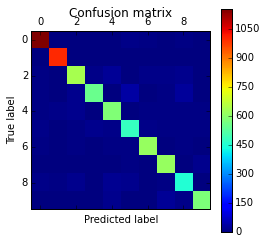

Test Data: 


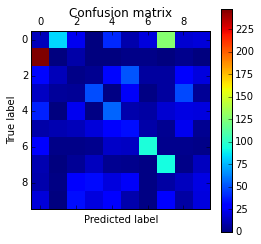

In [105]:
import matplotlib.pyplot as plt
%matplotlib inline
# Show confusion matrix in a separate window
print "Training Data: "
plt.matshow(cm1)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Show confusion matrix in a separate window
print "Test Data: "
plt.matshow(cm2)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [90]:
print myNN.runNN(train[0])

[1.0, 1.0, 1.8599724028049971e-06, 1.0, 0.99999930900859357, 1.0, 1.0, 3.5678539262156861e-19, 0.99997159030914329, 8.595417956937964e-25]
